#  Adapting our Bot accordingly to the Hypothesis

In [44]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
import time
from datetime import datetime

df = pd.read_csv("binance_data.csv")

# Print column names
print("Columns in CSV:", df.columns)

# Show first few rows
print(df.head())

print(df.tail())

Columns in CSV: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')
             timestamp      open      high       low     close    volume
0  2025-02-28 04:24:00  80592.45  80647.66  80560.00  80592.17  31.37624
1  2025-02-28 04:25:00  80592.17  80592.17  80426.60  80579.85  42.47261
2  2025-02-28 04:26:00  80579.85  80645.99  80512.01  80628.79  31.67002
3  2025-02-28 04:27:00  80628.79  80628.79  80480.01  80519.09  33.08512
4  2025-02-28 04:28:00  80519.09  80519.10  80272.01  80362.96  28.54599
               timestamp      open      high       low     close    volume
495  2025-02-28 12:39:00  80270.01  80300.85  80183.51  80201.08  24.15502
496  2025-02-28 12:40:00  80201.08  80216.54  80125.10  80156.58  51.40798
497  2025-02-28 12:41:00  80156.95  80199.98  80079.04  80151.16  34.67582
498  2025-02-28 12:42:00  80151.16  80199.97  80115.24  80180.56  21.55687
499  2025-02-28 12:43:00  80180.57  80214.36  80178.17  80214.35   1.90005


In [45]:
# CONFIGURATION PARAMETERS FOR HYPOTHESIS
# Grid Trading Parameters
symbol = 'BTC/USDT'  # Trading pair
base_grid_step = 0.010  # Base grid step size (1.0%) - increased for wider profit margins
max_grid_count = 40  # Maximum number of grid levels - reduced for focus
min_grid_count = 15  # Minimum number of grid levels - reduced for focus
position_size_percentage = 0.04  # Fixed position size as percentage of initial capital - reduced for risk management
initial_capital = 10000  # Initial capital in USDT
max_drawdown_limit = 0.18  # Maximum allowed drawdown (18%) - slightly reduced for better risk management
volatility_window = 24  # Window for volatility calculation - increased for better assessment
volatility_weight = 1.8  # Weight of volatility in grid spacing adjustment - increased for better adaptation
trend_window = 48  # Window for trend detection
profit_take_threshold = 0.015  # Minimum profit to take (1.5%)
max_open_positions = 10  # Maximum number of concurrent open positions
min_profit_factor = 2.0  # Minimum profit-to-loss ratio for trading

# Performance tracking
visualize_results = True  # Generate visualization after trading






### Trend Dectection

In [46]:

def detect_trend(prices, window=trend_window):
    """Detect market trend using exponential moving averages"""
    if len(prices) < window:
        return 'neutral'  # Not enough data
    
    # Calculate short and long EMAs
    short_ema_period = max(5, window // 8)
    long_ema_period = max(20, window // 2)
    
    short_ema = pd.Series(prices).ewm(span=short_ema_period, adjust=False).mean().iloc[-1]
    long_ema = pd.Series(prices).ewm(span=long_ema_period, adjust=False).mean().iloc[-1]
    
    # Calculate slope of EMAs
    short_ema_slope = pd.Series(prices).ewm(span=short_ema_period, adjust=False).mean().diff(5).iloc[-1]
    long_ema_slope = pd.Series(prices).ewm(span=long_ema_period, adjust=False).mean().diff(5).iloc[-1]
    
    # Determine trend
    if short_ema > long_ema and short_ema_slope > 0 and long_ema_slope > 0:
        return 'strong_uptrend'
    elif short_ema > long_ema and short_ema_slope > 0:
        return 'uptrend'
    elif short_ema < long_ema and short_ema_slope < 0 and long_ema_slope < 0:
        return 'strong_downtrend'
    elif short_ema < long_ema and short_ema_slope < 0:
        return 'downtrend'
    else:
        return 'neutral'

### Volatility Calculation

In [47]:

def calculate_volatility(prices, window=volatility_window):
    """Calculate rolling volatility based on price data with noise reduction"""
    if len(prices) < window:
        # Not enough data, use a default value
        return 0.02  # Default 2% volatility
    
    # Apply Savitzky-Golay filter to smooth the prices and reduce noise
    if len(prices) > window + 5:
        prices_smooth = savgol_filter(prices[-window*2:], min(11, window//2*2+1), 3)
        prices_to_use = prices_smooth[-window:]
    else:
        prices_to_use = prices[-window:]
    
    # Calculate log returns instead of percentage returns for better statistical properties
    log_returns = np.diff(np.log(prices_to_use))
    
    # Calculate standard deviation of returns (volatility)
    volatility = np.std(log_returns) * np.sqrt(24)  # Annualized to daily
    
    # Apply a minimum volatility floor
    return max(volatility, 0.015)


### RESISTANCE DETECTION

In [48]:

def detect_support_resistance(prices, window=100, threshold=0.02):
    """Detect support and resistance levels"""
    if len(prices) < window:
        return [], []  # Not enough data
    
    recent_prices = prices[-window:]
    
    # Find local minima and maxima
    supports = []
    resistances = []
    
    for i in range(2, len(recent_prices)-2):
        # Check for local minimum (support)
        if (recent_prices[i-2] > recent_prices[i] and 
            recent_prices[i-1] > recent_prices[i] and 
            recent_prices[i] < recent_prices[i+1] and 
            recent_prices[i] < recent_prices[i+2]):
            supports.append(recent_prices[i])
        
        # Check for local maximum (resistance)
        if (recent_prices[i-2] < recent_prices[i] and 
            recent_prices[i-1] < recent_prices[i] and 
            recent_prices[i] > recent_prices[i+1] and 
            recent_prices[i] > recent_prices[i+2]):
            resistances.append(recent_prices[i])
    
    # Cluster similar levels (within threshold)
    clustered_supports = []
    for s in supports:
        if not any(abs(s-cs)/cs < threshold for cs in clustered_supports):
            clustered_supports.append(s)
    
    clustered_resistances = []
    for r in resistances:
        if not any(abs(r-cr)/cr < threshold for cr in clustered_resistances):
            clustered_resistances.append(r)
    
    return clustered_supports, clustered_resistances



##### ADAPTIVE GRID CALCULATION 

In [49]:

def calculate_adaptive_grids(current_price, historical_prices, capital_per_grid):
    """Calculate grid levels with adaptive spacing based on volatility and trend"""
    # Calculate current volatility
    current_volatility = calculate_volatility(historical_prices)
    
    # Detect current trend
    current_trend = detect_trend(historical_prices)
    
    # Detect support/resistance levels
    supports, resistances = detect_support_resistance(historical_prices)
    
    # Scale volatility to determine grid spacing
    # Higher volatility = wider grid spacing
    grid_step = base_grid_step * (1 + current_volatility * volatility_weight)
    
    # Adjust grid step based on trend
    if current_trend in ['strong_uptrend', 'uptrend']:
        grid_step *= 1.2  # Wider grids in uptrend to catch bigger moves
    elif current_trend in ['strong_downtrend', 'downtrend']:
        grid_step *= 0.9  # Tighter grids in downtrend to be more conservative
    
    # Adjust grid count based on volatility and trend
    volatility_factor = 1 + (current_volatility * 8)
    
    if current_trend in ['strong_uptrend', 'uptrend']:
        grid_count = int(max(min_grid_count, min(max_grid_count, max_grid_count / (volatility_factor * 0.8))))
    elif current_trend in ['strong_downtrend', 'downtrend']:
        grid_count = int(max(min_grid_count, min(max_grid_count, max_grid_count / (volatility_factor * 1.2))))
    else:
        grid_count = int(max(min_grid_count, min(max_grid_count, max_grid_count / volatility_factor)))
    
    # Calculate range based on volatility and trend
    price_range = current_price * grid_step * grid_count
    
    # Create asymmetric grid based on trend
    if current_trend in ['strong_uptrend', 'uptrend']:
        # More levels above current price in uptrend
        lower_bound = current_price - (price_range * 0.4)
        upper_bound = current_price + (price_range * 0.6)
    elif current_trend in ['strong_downtrend', 'downtrend']:
        # More levels below current price in downtrend
        lower_bound = current_price - (price_range * 0.7)
        upper_bound = current_price + (price_range * 0.3)
    else:
        # Balanced in neutral trend
        lower_bound = current_price - (price_range * 0.5)
        upper_bound = current_price + (price_range * 0.5)
    
    # Generate grid levels
    grid_prices = []
    for i in range(grid_count):
        # Calculate position in range (0 to 1)
        position = i / (grid_count - 1)
        
        # Apply non-linear spacing (denser near current price)
        if position < 0.5:
            # Below current price
            adjusted_position = 0.5 * (position / 0.5) ** 0.85
        else:
            # Above current price
            adjusted_position = 0.5 + 0.5 * ((position - 0.5) / 0.5) ** 1.15
        
        # Calculate price at this position
        price = lower_bound + (upper_bound - lower_bound) * adjusted_position
        grid_prices.append(round(price, 2))
    
    # Add the current price as a grid level (if not already included)
    current_price_rounded = round(current_price, 2)
    if current_price_rounded not in grid_prices:
        grid_prices.append(current_price_rounded)
        grid_prices.sort()
    
    # Add key support/resistance levels to the grid
    for level in supports + resistances:
        level_rounded = round(level, 2)
        if level_rounded not in grid_prices and lower_bound <= level <= upper_bound:
            grid_prices.append(level_rounded)
    
    grid_prices = sorted(grid_prices)
    
    # Calculate dynamic take-profit levels based on volatility and trend
    take_profits = {}
    for price in grid_prices:
        # Higher volatility and strong trend = higher profit target
        if current_trend in ['strong_uptrend', 'strong_downtrend']:
            profit_multiplier = 1.5
        elif current_trend in ['uptrend', 'downtrend']:
            profit_multiplier = 1.2
        else:
            profit_multiplier = 1.0
        
        take_profit_pct = max(profit_take_threshold, current_volatility * 0.8 * profit_multiplier)
        take_profits[price] = price * (1 + take_profit_pct)
    
    # Calculate stop-loss levels for each grid
    stop_losses = {}
    for price in grid_prices:
        # Dynamic stop-loss based on volatility and trend
        if current_trend in ['strong_downtrend', 'downtrend']:
            # Tighter stops in downtrend
            stop_loss_multiplier = 1.2
        else:
            stop_loss_multiplier = 1.0
        
        # Higher volatility = wider stop-loss but capped by max_drawdown_limit
        stop_loss_percentage = min(max_drawdown_limit, 
                               max(0.01, current_volatility * 2.5 * stop_loss_multiplier))
        
        stop_losses[price] = price * (1 - stop_loss_percentage)
    
    # Calculate BTC amount per grid based on position size and current price
    btc_per_grid = capital_per_grid / current_price
    
    return {
        'grid_prices': grid_prices,
        'stop_losses': stop_losses,
        'take_profits': take_profits,
        'volatility': current_volatility,
        'trend': current_trend,
        'grid_step': grid_step,
        'btc_per_grid': btc_per_grid,
        'grid_count': len(grid_prices),
        'supports': supports,
        'resistances': resistances
    }

#### TRADING SIMULATION 

In [50]:

def simulate_grid_trading(df, initial_capital):
    # Initialize tracking variables
    capital = initial_capital  # Initial capital in USDT
    btc_holding = 0  # Amount of BTC held
    available_capital = initial_capital  # Capital available for trading
    
    # Fixed position size per grid
    capital_per_grid = initial_capital * position_size_percentage
    
    # Performance tracking arrays
    trade_log = []  # Store trade records
    portfolio_values = []  # Track portfolio value over time
    btc_positions = []  # Track BTC position over time
    prices = []  # Track prices over time
    timestamps = []  # Track timestamps
    drawdowns = []  # Track drawdowns
    volatilities = []  # Track volatilities
    grid_counts = []  # Track number of grid levels
    current_drawdown = 0  # Current drawdown
    peak_value = initial_capital  # Peak portfolio value
    
    # Grid state tracking
    active_grids = {}  # Track active grid positions
    
    # Fee calculation
    fee_rate = 0.001  # 0.1% fee
    total_fees = 0
    
    # Keep historical prices for volatility calculation
    historical_prices = []
    
    # Metrics for adaptive trading
    consecutive_losses = 0
    total_profit = 0
    total_loss = 0
    
    print("\n===== SIMULATING ENHANCED ADAPTIVE GRID TRADING =====")
    for index, row in df.iterrows():
        current_price = row['close']
        timestamp = row['timestamp']
        
        # Update historical prices for volatility calculation
        historical_prices.append(current_price)
        if len(historical_prices) > volatility_window * 3:
            historical_prices = historical_prices[-volatility_window*3:]
        
        # Recalculate adaptive grids periodically or on significant price changes
        recalculate = False
        
        # Force recalculation at the start or when we have no active grids
        if index % 24 == 0 or index == 0 or len(active_grids) == 0:
            recalculate = True
        
        # Also recalculate if price has moved significantly
        if len(prices) > 0:
            price_change = abs(current_price - prices[-1]) / prices[-1]
            if price_change > 0.02:  # 2% price change
                recalculate = True
        
        if recalculate:
            # Calculate new grid levels based on current market conditions
            grid_data = calculate_adaptive_grids(
                current_price, historical_prices, capital_per_grid)
            
            grid_prices = grid_data['grid_prices']
            stop_losses = grid_data['stop_losses']
            take_profits = grid_data['take_profits']
            current_volatility = grid_data['volatility']
            current_trend = grid_data['trend']
            current_grid_step = grid_data['grid_step']
            btc_per_grid = grid_data['btc_per_grid']
            grid_count = grid_data['grid_count']
            supports = grid_data['supports']
            resistances = grid_data['resistances']
            
            # Track metrics
            volatilities.append(current_volatility)
            grid_counts.append(grid_count)
            
            print(f"\n[{timestamp}] Recalculating grids:")
            print(f"Current price: {current_price:.2f}")
            print(f"Volatility: {current_volatility:.4f}")
            print(f"Market trend: {current_trend}")
            print(f"Grid step: {current_grid_step:.4f} ({current_grid_step*100:.2f}%)")
            print(f"Grid count: {grid_count}")
            print(f"Price range: {grid_prices[0]:.2f} - {grid_prices[-1]:.2f}")
            
            # Adjust position sizing based on market conditions and past performance
            profit_factor = abs(total_profit / total_loss) if total_loss != 0 else float('inf')
            
            # Risk management: adjust position size based on performance
            if consecutive_losses >= 3:
                # Reduce position size after consecutive losses
                effective_position_size = capital_per_grid * 0.7
                print(f"⚠️ Reducing position size due to {consecutive_losses} consecutive losses")
            elif profit_factor < min_profit_factor and total_profit > 0 and total_loss > 0:
                # Reduce position size if profit factor is below target
                effective_position_size = capital_per_grid * 0.8
                print(f"⚠️ Reducing position size due to low profit factor ({profit_factor:.2f})")
            elif current_trend in ['strong_downtrend', 'downtrend']:
                # Reduce position size in downtrends
                effective_position_size = capital_per_grid * 0.8
                print(f"⚠️ Reducing position size due to downtrend")
            elif current_trend in ['strong_uptrend'] and profit_factor > min_profit_factor:
                # Slightly increase position size in strong uptrends with good performance
                effective_position_size = capital_per_grid * 1.1
                print(f"✅ Increasing position size due to strong uptrend and good performance")
            else:
                effective_position_size = capital_per_grid
        
        # Calculate current portfolio value
        current_portfolio_value = available_capital + (btc_holding * current_price)
        
        # Update peak value if new high
        if current_portfolio_value > peak_value:
            peak_value = current_portfolio_value
        
        # Calculate drawdown
        if peak_value > 0:
            current_drawdown = (peak_value - current_portfolio_value) / peak_value
        else:
            current_drawdown = 0
        
        # Track metrics
        portfolio_values.append(current_portfolio_value)
        btc_positions.append(btc_holding)
        prices.append(current_price)
        timestamps.append(timestamp)
        drawdowns.append(current_drawdown * 100)  # Store as percentage
        
        # Check take-profit opportunities for active positions
        took_profit = []
        for grid_price, position in active_grids.items():
            if current_price >= position['take_profit']:
                # Take profit triggered
                position_size = position['amount']
                position_value = position_size * current_price
                
                # Calculate P&L
                buy_value = position['buy_price'] * position_size
                profit = position_value - buy_value
                
                # Apply fee
                fee = position_value * fee_rate
                total_fees += fee
                
                trade_log.append({
                    "type": "TAKE_PROFIT",
                    "grid_price": grid_price,
                    "price": current_price,
                    "timestamp": timestamp,
                    "buy_price": position['buy_price'],
                    "btc_amount": position_size,
                    "usdt_value": position_value - fee,
                    "profit": profit - fee,
                    "drawdown": current_drawdown * 100,
                    "volatility": current_volatility * 100
                })
                
                # Update capital and holdings
                available_capital += (position_value - fee)
                btc_holding -= position_size
                took_profit.append(grid_price)
                
                # Update performance metrics
                total_profit += (profit - fee)
                consecutive_losses = 0  # Reset on profit
                
                print(f"💰 TAKE PROFIT at {current_price:.2f} | Grid: {grid_price:.2f} | Profit: {profit-fee:.2f} USDT | +{(profit/buy_value*100):.2f}%")
        
        # Remove positions where profit was taken
        for grid_price in took_profit:
            if grid_price in active_grids:
                del active_grids[grid_price]
        
        # Check stop losses for active grid positions
        stopped_grids = []
        for grid_price, position in active_grids.items():
            if current_price <= position['stop_loss']:
                # Stop loss triggered
                position_size = position['amount']
                position_value = position_size * current_price
                
                # Calculate P&L
                buy_value = position['buy_price'] * position_size
                profit = position_value - buy_value
                
                # Apply fee
                fee = position_value * fee_rate
                total_fees += fee
                
                trade_log.append({
                    "type": "STOP_LOSS",
                    "grid_price": grid_price,
                    "price": current_price,
                    "timestamp": timestamp,
                    "buy_price": position['buy_price'],
                    "btc_amount": position_size,
                    "usdt_value": position_value - fee,
                    "profit": profit - fee,
                    "drawdown": current_drawdown * 100,
                    "volatility": current_volatility * 100
                })
                
                # Update capital and holdings
                available_capital += (position_value - fee)
                btc_holding -= position_size
                stopped_grids.append(grid_price)
                
                # Update performance metrics
                total_loss += abs(profit - fee)
                consecutive_losses += 1
                
                print(f"🔴 STOP LOSS at {current_price:.2f} | Grid: {grid_price:.2f} | Loss: {profit-fee:.2f} USDT | {(profit/buy_value*100):.2f}%")
        
        # Remove stopped out positions
        for grid_price in stopped_grids:
            if grid_price in active_grids:
                del active_grids[grid_price]
        
        # Check for new positions only if we're not at the maximum
        if len(active_grids) < max_open_positions:
            # Check for buy opportunities on grid levels
            for grid_price in grid_prices:
                # Skip if we already have a position at this grid level
                if grid_price in active_grids:
                    continue
                
                price_diff = abs(current_price - grid_price) / grid_price
                
                # Precise price matching (0.1% tolerance)
                if price_diff <= 0.001:
                    # Buy at support or when price is below grid level in uptrend
                    should_buy = False
                    buy_reason = ""
                    
                    # Buy at support level
                    if any(abs(grid_price - s)/s < 0.01 for s in supports):
                        should_buy = True
                        buy_reason = "support"
                    # Buy when price crosses down through grid in uptrend
                    elif current_price <= grid_price and current_trend in ['uptrend', 'strong_uptrend']:
                        should_buy = True
                        buy_reason = "uptrend_dip"
                    # Buy on oversold condition in neutral trend
                    elif current_price <= grid_price and current_trend == 'neutral' and len(prices) > 2 and prices[-1] < prices[-2]:
                        should_buy = True
                        buy_reason = "price_dip"
                    # Buy at key levels in any trend (if price is close to grid price)
                    elif price_diff < 0.0005:
                        should_buy = True
                        buy_reason = "key_level"
                    
                    if should_buy and available_capital >= effective_position_size and current_drawdown < max_drawdown_limit:
                        # Calculate amount to buy (adjust for current price)
                        btc_amount = effective_position_size / current_price
                        cost = btc_amount * current_price
                        
                        # Apply fee
                        fee = cost * fee_rate
                        total_fees += fee
                        
                        if available_capital >= (cost + fee):
                            # Calculate take-profit level based on volatility and trend
                            if current_trend in ['strong_uptrend']:
                                tp_multiplier = 1.5
                            elif current_trend in ['uptrend']:
                                tp_multiplier = 1.2
                            else:
                                tp_multiplier = 1.0
                                
                            take_profit_pct = max(profit_take_threshold, current_volatility * 0.8 * tp_multiplier)
                            take_profit_price = current_price * (1 + take_profit_pct)
                            
                            # Record the trade
                            trade_log.append({
                                "type": "BUY",
                                "grid_price": grid_price,
                                "price": current_price,
                                "timestamp": timestamp,
                                "btc_amount": btc_amount,
                                "usdt_value": cost,
                                "fee": fee,
                                "drawdown": current_drawdown * 100,
                                "volatility": current_volatility * 100,
                                "reason": buy_reason
                            })
                            
                            # Track the position
                            active_grids[grid_price] = {
                                'amount': btc_amount,
                                'buy_price': current_price,
                                'stop_loss': stop_losses[grid_price],
                                'take_profit': take_profit_price
                            }
                            
                            # Update capital and holdings
                            available_capital -= (cost + fee)
                            btc_holding += btc_amount
                            
                            print(f"🟢 BUY at {current_price:.2f} | Grid: {grid_price:.2f} | BTC: {btc_amount:.6f} | Cost: {cost:.2f} USDT | TP: {take_profit_price:.2f} | SL: {stop_losses[grid_price]:.2f} | Reason: {buy_reason}")
                    
                    # Sell at resistance or when price crosses up through grid in downtrend
                    should_sell = False
                    sell_reason = ""
                    
                    # Sell at resistance level
                    if any(abs(grid_price - r)/r < 0.01 for r in resistances):
                        should_sell = True
                        sell_reason = "resistance"
                    # Sell when price crosses up through grid in downtrend
                    elif current_price >= grid_price and current_trend in ['downtrend', 'strong_downtrend']:
                        should_sell = True
                        sell_reason = "downtrend_rally"
                    # Sell on overbought condition in neutral trend
                    elif current_price >= grid_price and current_trend == 'neutral' and len(prices) > 2 and prices[-1] > prices[-2]:
                        should_sell = True
                        sell_reason = "price_rally"
                    # Sell if we're in serious drawdown
                    elif current_price >= grid_price and current_drawdown > max_drawdown_limit * 0.8:
                        should_sell = True
                        sell_reason = "high_drawdown"
                    
                    if should_sell and grid_price in active_grids:
                        position = active_grids[grid_price]
                        position_size = position['amount']
                        position_value = position_size * current_price
                        
                        # Calculate P&L
                        buy_value = position['buy_price'] * position_size
                        profit = position_value - buy_value
                        
                        # Apply fee
                        fee = position_value * fee_rate
                        total_fees += fee
                        
                        # Record the trade
                        trade_log.append({
                            "type": "SELL",
                            "grid_price": grid_price,
                            "price": current_price,
                            "timestamp": timestamp,
                            "buy_price": position['buy_price'],
                            "btc_amount": position_size,
                            "usdt_value": position_value - fee,
                            "profit": profit - fee,
                            "drawdown": current_drawdown * 100,
                            "volatility": current_volatility * 100,
                            "reason": sell_reason
                        })
                        
                        # Update performance metrics
                        if profit > 0:
                            total_profit += (profit - fee)
                            consecutive_losses = 0  # Reset consecutive losses
                        else:
                            total_loss += abs(profit - fee)
                            consecutive_losses += 1
                        
                        # Update capital and holdings
                        available_capital += (position_value - fee)
                        btc_holding -= position_size
                        
                        # Remove the position
                        del active_grids[grid_price]
                        
                        print(f"🔵 SELL at {current_price:.2f} | Grid: {grid_price:.2f} | BTC: {position_size:.6f} | Value: {position_value:.2f} | Profit: {profit-fee:.2f} USDT | Reason: {sell_reason}")
    # Calculate final portfolio value
    final_portfolio_value = available_capital + (btc_holding * prices[-1])
    total_profit_final = final_portfolio_value - initial_capital
    max_drawdown = max(drawdowns) if drawdowns else 0
    avg_volatility = sum(volatilities) / len(volatilities) if volatilities else 0
    avg_grid_count = sum(grid_counts) / len(grid_counts) if grid_counts else 0
    
    # Create results summary
    print("\n===== TRADING SIMULATION RESULTS =====")
    print(f"Initial Capital: {initial_capital:.2f} USDT")
    print(f"Final Portfolio: {final_portfolio_value:.2f} USDT")
    print(f"Total Profit: {total_profit_final:.2f} USDT ({(total_profit_final/initial_capital*100):.2f}%)")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Profit-to-Drawdown Ratio: {abs(total_profit_final/(max_drawdown/100*initial_capital)):.2f}")
    print(f"Average Volatility: {avg_volatility*100:.2f}%")
    print(f"Average Grid Count: {avg_grid_count:.1f}")
    print(f"Total Fees Paid: {total_fees:.2f} USDT")
    print(f"Remaining BTC: {btc_holding:.6f} (Value: {btc_holding*prices[-1]:.2f} USDT)")
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'timestamp': timestamps,
        'price': prices,
        'portfolio_value': portfolio_values,
        'btc_position': btc_positions,
        'drawdown': drawdowns
    })
    
    # Convert trade log to dataframe
    trades_df = pd.DataFrame(trade_log) if trade_log else pd.DataFrame()
    
    return results_df, trades_df, total_profit_final, max_drawdown
    

## Visualizing the results

### Price and Portfolio over time
### Profit/Loss Distribution

Loading data from binance_data.csv...
Starting simulation with 500 data points...

===== SIMULATING ENHANCED ADAPTIVE GRID TRADING =====

[2025-02-28 04:24:00] Recalculating grids:
Current price: 80592.17
Volatility: 0.0200
Market trend: neutral
Grid step: 0.0104 (1.04%)
Grid count: 35
Price range: 66398.28 - 94786.06
🟢 BUY at 80592.17 | Grid: 80592.17 | BTC: 0.004963 | Cost: 400.00 USDT | TP: 81881.64 | SL: 76562.56 | Reason: key_level
🟢 BUY at 80216.65 | Grid: 80225.73 | BTC: 0.004986 | Cost: 400.00 USDT | TP: 81500.12 | SL: 76214.44 | Reason: key_level
🟢 BUY at 80791.99 | Grid: 80846.74 | BTC: 0.004951 | Cost: 400.00 USDT | TP: 82084.66 | SL: 76804.40 | Reason: price_dip

[2025-02-28 04:48:00] Recalculating grids:
Current price: 80618.14
Volatility: 0.0150
Market trend: neutral
Grid step: 0.0103 (1.03%)
Grid count: 35
Price range: 66129.04 - 95107.24
🟢 BUY at 80618.14 | Grid: 80618.14 | BTC: 0.004962 | Cost: 400.00 USDT | TP: 81827.41 | SL: 77594.96 | Reason: price_dip
🟢 BUY at 7992

/var/folders/zh/fqwlrsqs1ms6lk18kb70z3200000gn/T/ipykernel_52430/2887028070.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


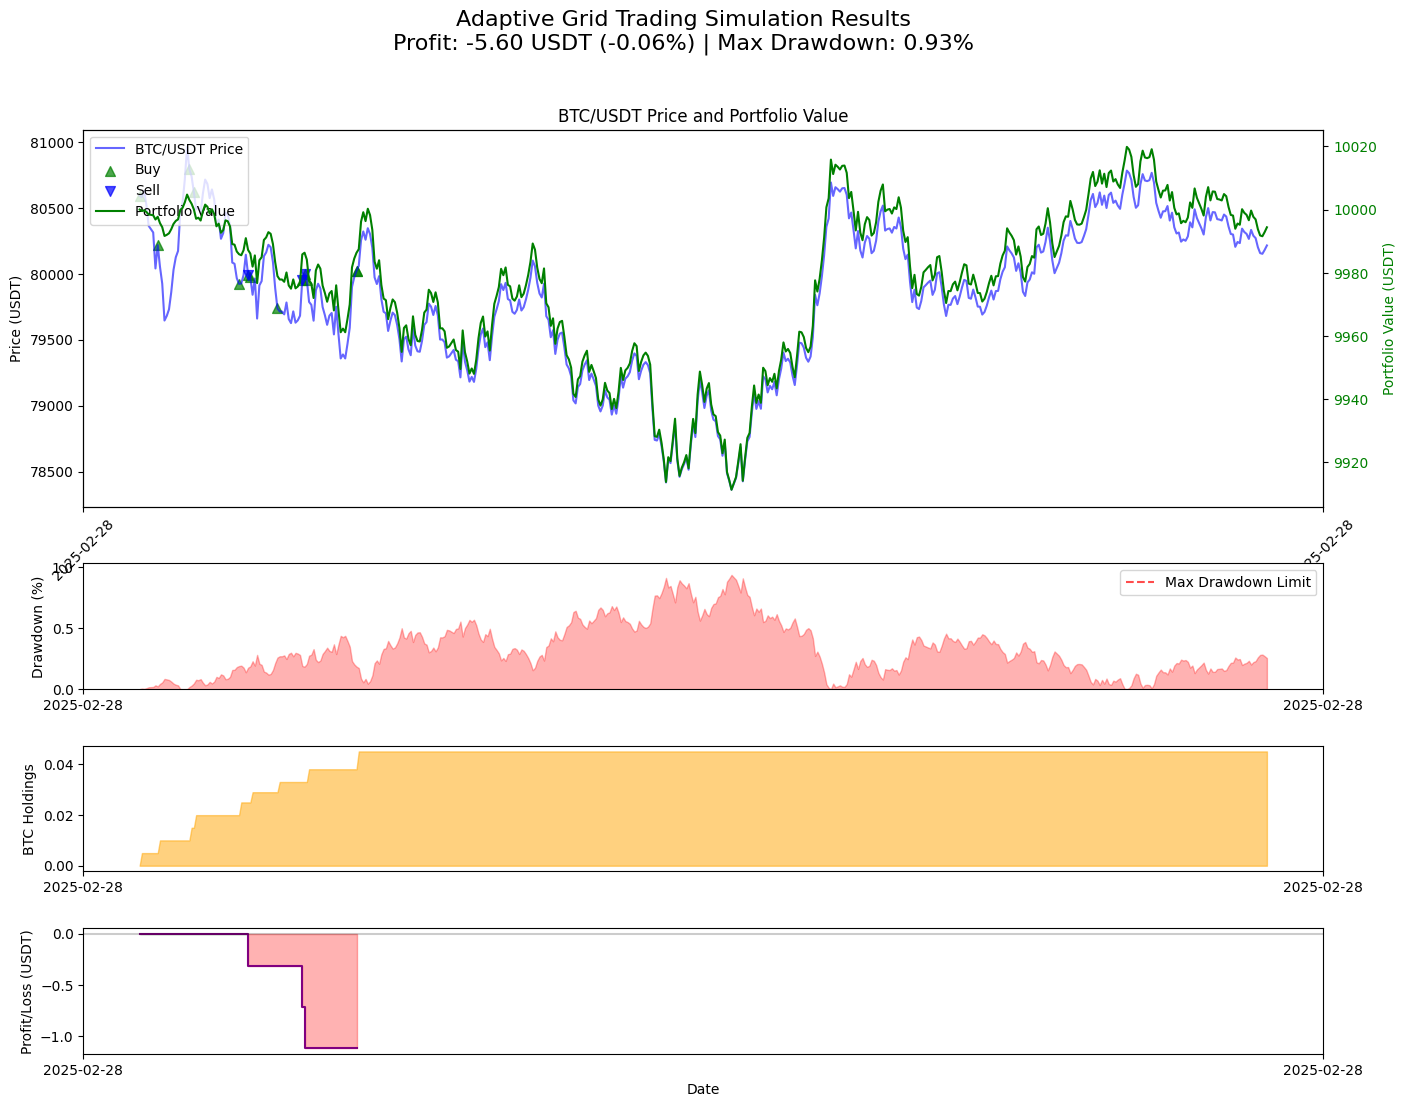

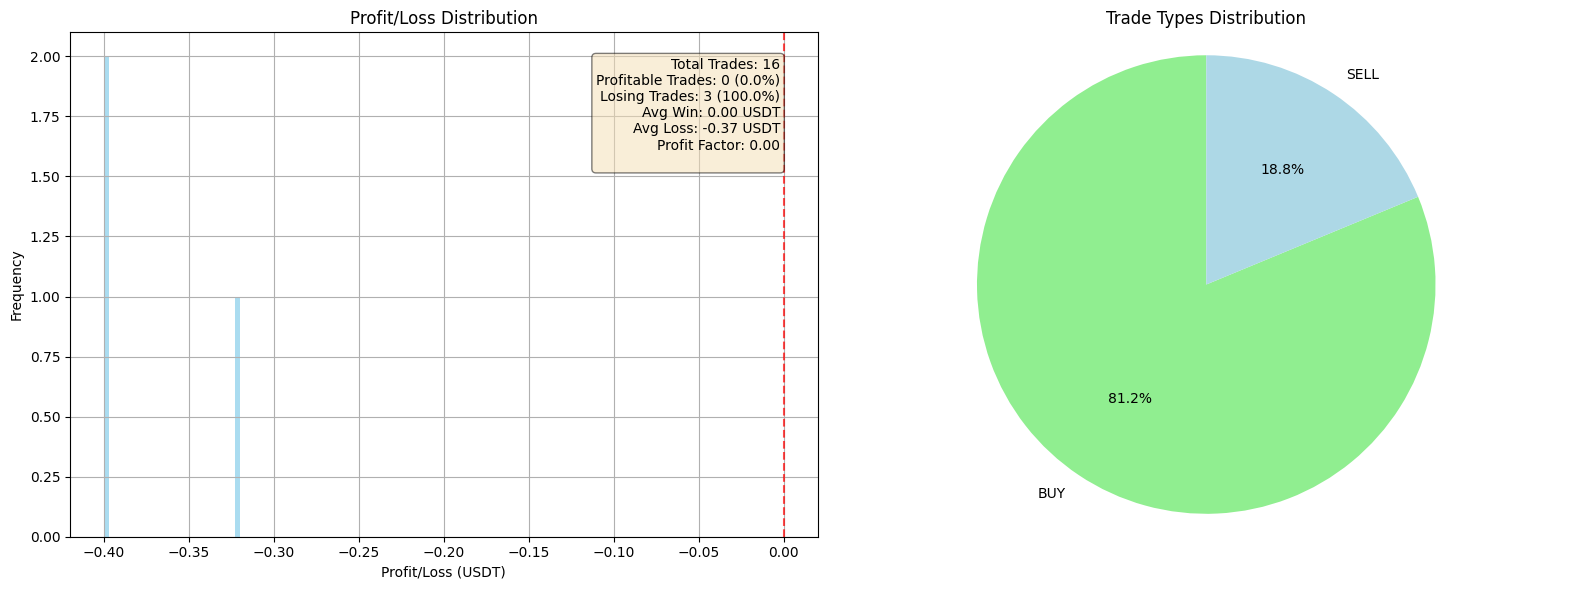

In [51]:
def visualize_trading_results(results_df, trades_df, initial_capital):
    print("\n===== GENERATING VISUALIZATIONS =====")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Create GridSpec for more control over plot layout
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 1, 1, 1], hspace=0.3)
    
    # Price and portfolio value chart (with trades)
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title('BTC/USDT Price and Portfolio Value')
    ax1.set_ylabel('Price (USDT)')
    
    # Format date
    date_format = DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(date_format)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot price
    ax1.plot(results_df['timestamp'], results_df['price'], 'b-', alpha=0.6, label='BTC/USDT Price')
    
    # Create second y-axis for portfolio value
    ax1b = ax1.twinx()
    ax1b.set_ylabel('Portfolio Value (USDT)', color='g')
    ax1b.plot(results_df['timestamp'], results_df['portfolio_value'], 'g-', label='Portfolio Value')
    ax1b.tick_params(axis='y', labelcolor='g')
    
    # Add buy and sell markers if trades exist
    if not trades_df.empty:
        # Filter trades by type
        buys = trades_df[trades_df['type'] == 'BUY']
        sells = trades_df[trades_df['type'] == 'SELL']
        take_profits = trades_df[trades_df['type'] == 'TAKE_PROFIT']
        stop_losses = trades_df[trades_df['type'] == 'STOP_LOSS']
        
        # Plot markers for different trade types
        if not buys.empty:
            ax1.scatter(buys['timestamp'], buys['price'], color='green', marker='^', s=50, alpha=0.7, label='Buy')
        if not sells.empty:
            ax1.scatter(sells['timestamp'], sells['price'], color='blue', marker='v', s=50, alpha=0.7, label='Sell')
        if not take_profits.empty:
            ax1.scatter(take_profits['timestamp'], take_profits['price'], color='purple', marker='*', s=80, alpha=0.7, label='Take Profit')
        if not stop_losses.empty:
            ax1.scatter(stop_losses['timestamp'], stop_losses['price'], color='red', marker='x', s=50, alpha=0.7, label='Stop Loss')
    
    # Combine legends from both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Drawdown chart
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.set_ylabel('Drawdown (%)')
    ax2.fill_between(results_df['timestamp'], results_df['drawdown'], 0, color='red', alpha=0.3)
    ax2.set_ylim(0, max(results_df['drawdown']) * 1.1 if not results_df['drawdown'].empty else 10)
    
    # Add a horizontal line at maximum allowed drawdown
    ax2.axhline(y=18, color='r', linestyle='--', alpha=0.7, label='Max Drawdown Limit')
    ax2.legend()
    
    # BTC Position chart
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.set_ylabel('BTC Holdings')
    ax3.fill_between(results_df['timestamp'], results_df['btc_position'], 0, color='orange', alpha=0.5)
    
    # Profit and Loss chart
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    ax4.set_ylabel('Profit/Loss (USDT)')
    ax4.set_xlabel('Date')
    
    # Calculate cumulative profit/loss over time
    if not trades_df.empty and 'profit' in trades_df.columns:
        # Convert timestamp to datetime if it's not already
        if not isinstance(trades_df['timestamp'].iloc[0], pd.Timestamp):
            trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
            
        # Sort by timestamp
        trades_df = trades_df.sort_values('timestamp')
        
        # Calculate cumulative profit
        trades_df['cumulative_profit'] = trades_df['profit'].fillna(0).cumsum()
        
        # Plot cumulative profit
        ax4.plot(trades_df['timestamp'], trades_df['cumulative_profit'], 'purple', label='Cumulative P&L')
        
        # Color the background based on profit or loss
        ax4.axhline(y=0, color='k', linestyle='-', alpha=0.2)
        ax4.fill_between(trades_df['timestamp'], trades_df['cumulative_profit'], 0, 
                        where=(trades_df['cumulative_profit'] >= 0),
                        color='green', alpha=0.3)
        ax4.fill_between(trades_df['timestamp'], trades_df['cumulative_profit'], 0, 
                        where=(trades_df['cumulative_profit'] < 0),
                        color='red', alpha=0.3)
    
    # Add title with performance summary
    total_profit = results_df['portfolio_value'].iloc[-1] - initial_capital if not results_df.empty else 0
    profit_percentage = (total_profit / initial_capital) * 100 if initial_capital > 0 else 0
    max_drawdown = max(results_df['drawdown']) if not results_df.empty else 0
    
    fig.suptitle(f'Adaptive Grid Trading Simulation Results\nProfit: {total_profit:.2f} USDT ({profit_percentage:.2f}%) | Max Drawdown: {max_drawdown:.2f}%', 
                fontsize=16)
    
    plt.tight_layout()
    
    # Add an additional plot for trade analysis
    if not trades_df.empty and 'profit' in trades_df.columns:
        # Create a new figure for trade analysis
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Profit distribution histogram
        ax1.set_title('Profit/Loss Distribution')
        ax1.set_xlabel('Profit/Loss (USDT)')
        ax1.set_ylabel('Frequency')
        
        trades_df['profit'].hist(bins=30, ax=ax1, color='skyblue', alpha=0.7)
        
        # Add vertical line at zero
        ax1.axvline(x=0, color='r', linestyle='--', alpha=0.7)
        
        # Add profit/loss statistics
        total_trades = len(trades_df)
        profitable_trades = len(trades_df[trades_df['profit'] > 0])
        losing_trades = len(trades_df[trades_df['profit'] <= 0])
        win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
        
        avg_win = trades_df[trades_df['profit'] > 0]['profit'].mean() if profitable_trades > 0 else 0
        avg_loss = trades_df[trades_df['profit'] <= 0]['profit'].mean() if losing_trades > 0 else 0
        
        profit_factor = abs(trades_df[trades_df['profit'] > 0]['profit'].sum() / 
                        trades_df[trades_df['profit'] < 0]['profit'].sum()) if trades_df[trades_df['profit'] < 0]['profit'].sum() != 0 else float('inf')
        
        stats_text = f"Total Trades: {total_trades}\n"
        stats_text += f"Profitable Trades: {profitable_trades} ({win_rate:.1f}%)\n"
        stats_text += f"Losing Trades: {losing_trades} ({100-win_rate:.1f}%)\n"
        stats_text += f"Avg Win: {avg_win:.2f} USDT\n"
        stats_text += f"Avg Loss: {avg_loss:.2f} USDT\n"
        stats_text += f"Profit Factor: {profit_factor:.2f}\n"
        
        # Position text in the upper right
        ax1.text(0.95, 0.95, stats_text,
                 transform=ax1.transAxes, fontsize=10,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Trade types pie chart
        ax2.set_title('Trade Types Distribution')
        
        if 'type' in trades_df.columns:
            trade_types = trades_df['type'].value_counts()
            labels = trade_types.index
            sizes = trade_types.values
            
            # Define colors for different trade types
            colors = {'BUY': 'lightgreen', 'SELL': 'lightblue', 'TAKE_PROFIT': 'purple', 'STOP_LOSS': 'red'}
            plot_colors = [colors.get(label, 'gray') for label in labels]
            
            # Plot pie chart
            ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
                   startangle=90, colors=plot_colors)
            ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        
        plt.tight_layout()
        
    return fig

# Add main execution section to run the simulation
def run_grid_trading_simulation(data_path):
    """
    Run the grid trading simulation with the provided data
    
    Parameters:
    data_path (str): Path to the CSV file with price data (should have timestamp and close columns)
    """
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    
    # Ensure timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Run simulation
    print(f"Starting simulation with {len(df)} data points...")
    results_df, trades_df, total_profit, max_drawdown = simulate_grid_trading(df, initial_capital)
    
    # Display summary statistics
    profit_percentage = (total_profit / initial_capital) * 100
    print(f"\nFinal Results:")
    print(f"Total Profit: {total_profit:.2f} USDT ({profit_percentage:.2f}%)")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    
    if not trades_df.empty:
        total_trades = len(trades_df)
        profitable_trades = len(trades_df[trades_df['profit'] > 0]) if 'profit' in trades_df.columns else 0
        win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.2f}%")
    
    # Visualize results
    if visualize_results:
        fig = visualize_trading_results(results_df, trades_df, initial_capital)
        plt.show()
    
    return results_df, trades_df

# Example usage
if __name__ == "__main__":
    # Use the correct data file path
    data_path = "binance_data.csv"
    results_df, trades_df = run_grid_trading_simulation(data_path)
    
    # Save results if needed
    results_df.to_csv("grid_trading_results.csv", index=False)
    trades_df.to_csv("grid_trading_trades.csv", index=False)